In [2]:

import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print('Done!')

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

In [3]:
import pandas as pd
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

In [6]:
df = load_dataframe('phi_psi_training/COLVAR',start=5000,stop=10000)
df

,time,phi,psi,opes.bias,d1,d2,d3,d4,d5,d6,...,d37,d38,d39,d40,d41,d42,d43,d44,d45,walker
0,500.0,-2.538520,-2.047860,-22.080700,0.149439,0.237522,0.240665,0.377983,0.459898,0.472801,...,0.366410,0.292090,0.435612,0.118244,0.137207,0.255804,0.217892,0.282346,0.147022,0
1,500.1,-3.028110,-1.937150,-26.381300,0.145088,0.228143,0.236894,0.381682,0.446238,0.487881,...,0.372527,0.296145,0.439337,0.120890,0.137187,0.246607,0.218064,0.263177,0.147487,0
2,500.2,-2.904800,-1.627920,-24.038200,0.147745,0.232338,0.240769,0.377470,0.449266,0.479123,...,0.364020,0.281703,0.426975,0.121332,0.133516,0.249872,0.223050,0.284304,0.147245,0
3,500.3,-2.409760,-1.582810,-22.301100,0.147317,0.243620,0.236517,0.372429,0.466330,0.457726,...,0.369227,0.279629,0.411836,0.122149,0.131965,0.246795,0.220445,0.285055,0.139147,0
4,500.4,-2.455680,-1.825370,-23.067200,0.148391,0.233864,0.244149,0.385961,0.455577,0.484519,...,0.370761,0.296720,0.440184,0.125214,0.136284,0.250334,0.223800,0.279036,0.145180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,999.5,-1.401580,0.077469,0.741693,0.150301,0.235155,0.238895,0.375845,0.470068,0.465368,...,0.302990,0.377619,0.507224,0.121753,0.134971,0.247536,0.220657,0.274530,0.147441,0
4996,999.6,-0.825665,-0.140009,-5.868870,0.153114,0.239006,0.239291,0.385824,0.481281,0.462256,...,0.309562,0.355437,0.464489,0.125372,0.133504,0.241480,0.223265,0.274319,0.143788,0
4997,999.7,-0.550443,-0.610147,-14.783300,0.153180,0.233274,0.243375,0.386578,0.475056,0.454623,...,0.331690,0.337113,0.473059,0.124231,0.133475,0.250263,0.225094,0.283799,0.149329,0
4998,999.8,-0.585327,-0.983375,-20.692000,0.148902,0.233117,0.235147,0.376983,0.468692,0.445182,...,0.340754,0.328136,0.467964,0.121828,0.133527,0.251239,0.218546,0.277832,0.148483,0


In [7]:
# Select input features
X = df.filter(regex='d').values
n_input = X.shape[1]

print(X.shape)

(5000, 45)


In [8]:
#------------- PARAMETERS -------------
temp              = 300.
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)

# Extract cvs from df

t = df['time'].values # save time
bias = df.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweights = beta*bias

In [23]:
#------------- PARAMETERS -------------
lag_time = 1.
#--------------------------------------

# create dataset
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,logweights=logweights,progress_bar=True)

# create datamodule (split train valid)
datamodule = DictModule(dataset,lengths=[0.8,0.2],random_split=False,shuffle=False)

datamodule

100%|██████████| 4979/4979 [00:02<00:00, 1952.12it/s]
/home/dhiman/miniconda3/lib/python3.9/site-packages/mlcolvar/data/datamodule.py:134: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


DictModule(dataset -> DictDataset( "data": [9940, 45], "data_lag": [9940, 45], "weights": [9940], "weights_lag": [9940] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=False),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=False))

In [24]:
from mlcolvar.cvs import DeepTICA

n_components = 2
nn_layers = [n_input, 30, 30, n_components]
options= {'nn': {'activation': 'shifted_softplus'}}

model = DeepTICA(nn_layers, options=options)
model

DeepTICA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (tica): TICA(in_features=2, out_features=2)
)

In [25]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=100)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dhiman/miniconda3/lib/python3.9/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | ?        | ?        
1 | norm_in | Normalization         | 0      | [45]     | [45]     
2 | nn      | FeedForward           | 2.4 K  | [45]     | [2]      
3 | tica    | TICA                  | 0      | [2]      | [2]      
-------------------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)


/home/dhiman/miniconda3/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 57.85it/s, v_num=3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.24it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 78.48it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 88.44it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 82.28it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 79.41it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 69.77it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 58.22it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 89.04it/s, v_num=3] 

Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 71.82it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 74.99it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 75.31it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 67.60it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 71.74it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 71.08it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 81.40it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 78.56it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 54.73it/s, v_

Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 77.11it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 80.11it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 79.06it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 36.11it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 73.45it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 78.81it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 75.96it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 77.97it/s, v

Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 54.57it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 90.58it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 105.07it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 77.33it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 81.91it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 84.27it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 77.31it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 80.74it/s, v_num=3]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s, 

Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 87.72it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 82.74it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 68.84it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 96.26it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 69.89it/s, v_num=3]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 81.97it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 77.42it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 78.71it/s, 

Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 64.60it/s, v_num=3]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 69.11it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 53.08it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 75.32it/s, v_num=3]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 98.15it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 65.83it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 73.10it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 79.09it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 48.08it/s, v

Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 71.21it/s, v_num=3]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 47.71it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 90.84it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 70.83it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 72.70it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 161: 100%|██████████| 1/1 [00:00<00:00, 85.66it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 100.53it/s,

Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 72.82it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 77.80it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 69.70it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 85.08it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 87.84it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 76.28it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 80.33it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 187: 100%|██████████| 1/1 [00:00<00:00, 61.67it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 81.05it/s,

Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 65.84it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 79.19it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 68.39it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 79.81it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 210: 100%|██████████| 1/1 [00:00<00:00, 84.01it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 211: 100%|██████████| 1/1 [00:00<00:00, 63.88it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 212: 100%|██████████| 1/1 [00:00<00:00, 95.21it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 213: 100%|██████████| 1/1 [00:00<00:00, 67.98it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 96.22it/s,

Epoch 231: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 55.95it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 83.00it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 234: 100%|██████████| 1/1 [00:00<00:00, 73.37it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 235: 100%|██████████| 1/1 [00:00<00:00, 80.04it/s, v_num=3]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 236: 100%|██████████| 1/1 [00:00<00:00, 74.20it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 237: 100%|██████████| 1/1 [00:00<00:00, 33.65it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 238: 100%|██████████| 1/1 [00:00<00:00, 58.65it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 239: 100%|██████████| 1/1 [00:00<00:00, 64.52it/s, 

Epoch 257: 100%|██████████| 1/1 [00:00<00:00, 85.69it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 258: 100%|██████████| 1/1 [00:00<00:00, 70.55it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 259: 100%|██████████| 1/1 [00:00<00:00, 84.90it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 260: 100%|██████████| 1/1 [00:00<00:00, 71.93it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 261: 100%|██████████| 1/1 [00:00<00:00, 66.60it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 262: 100%|██████████| 1/1 [00:00<00:00, 81.81it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 263: 100%|██████████| 1/1 [00:00<00:00, 71.82it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 264: 100%|██████████| 1/1 [00:00<00:00, 92.08it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 265: 100%|██████████| 1/1 [00:00<00:00, 52.35it/s,

Epoch 283: 100%|██████████| 1/1 [00:00<00:00, 69.95it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 284: 100%|██████████| 1/1 [00:00<00:00, 53.18it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 285: 100%|██████████| 1/1 [00:00<00:00, 67.43it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 286: 100%|██████████| 1/1 [00:00<00:00, 60.69it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 287: 100%|██████████| 1/1 [00:00<00:00, 63.79it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 288: 100%|██████████| 1/1 [00:00<00:00, 69.79it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 289: 100%|██████████| 1/1 [00:00<00:00, 67.13it/s, v_num=3]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 290: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 291: 100%|██████████| 1/1 [00:00<00:00, 65.81it/s, 

Epoch 308: 100%|██████████| 1/1 [00:00<00:00, 73.54it/s, v_num=3]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 308: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s, v_num=3]      


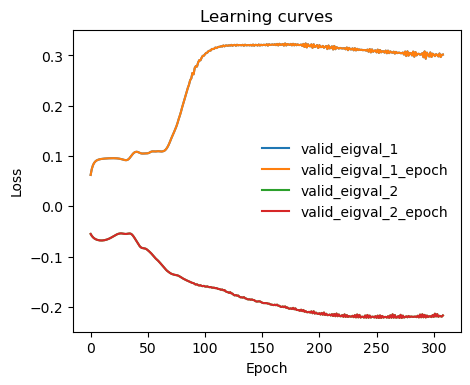

In [26]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

In [27]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

#X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) )
model.postprocessing = norm

Text(0.5, 0, 'Deep-TICA 2')

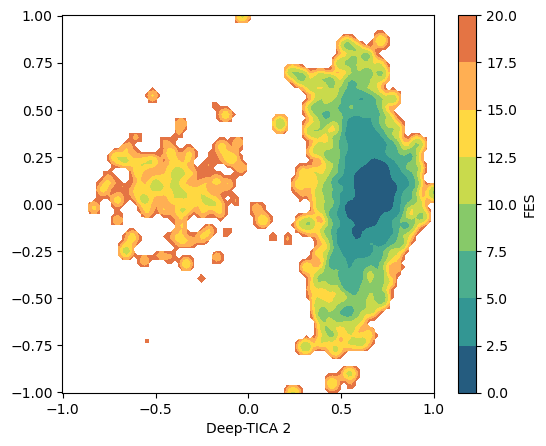

In [28]:
from mlcolvar.utils.fes import compute_fes

fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

w = np.exp(logweights)
fes,grid,bounds,error = compute_fes(s,
                                    weights=w,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, ax = ax, eps=1e-10)

ax.set_xlabel('Deep-TICA 1')
ax.set_xlabel('Deep-TICA 2')

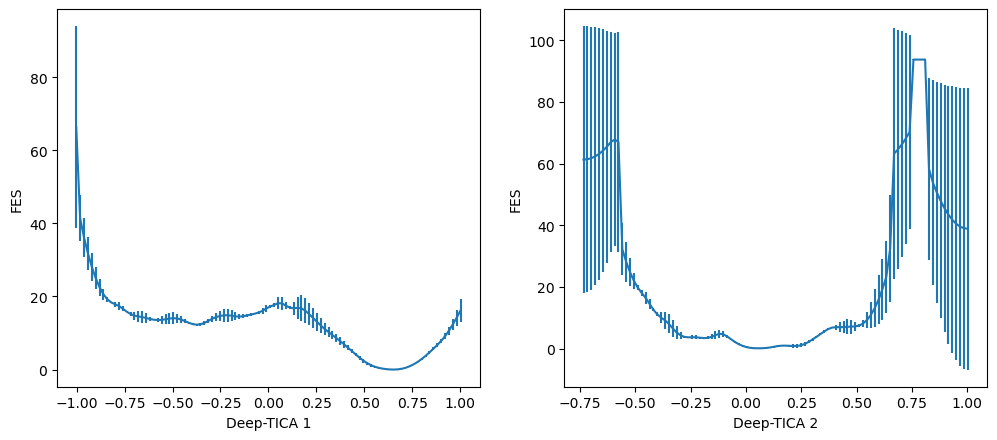

In [29]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

for i in range(n_components):
    w = np.exp(logweights)

    # restrict the second CV to the points in which the first is < 0
    fes,grid,bounds,error = compute_fes(s[:,i] if i == 0 else s[s[:,0] < 0, i ],
                                        weights=w if i == 0 else w[s[:,0] < 0 ],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

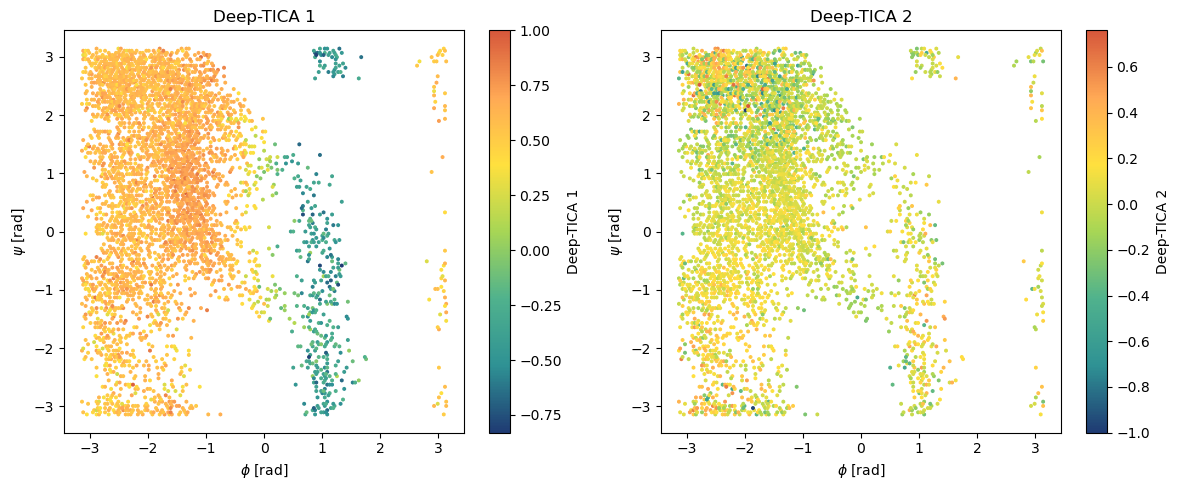

In [30]:
fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

x = df['phi'].values
y = df['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

In [31]:
## Save the model
x = torch.rand(n_input, dtype=torch.float32, requires_grad=True).unsqueeze(0)
traced_cv = torch.jit.trace ( model, example_inputs=x)
filename='model_deeptica.pt'
traced_cv.save(filename)

/home/dhiman/miniconda3/lib/python3.9/site-packages/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()
/home/dhiman/miniconda3/lib/python3.9/site-packages/torch/jit/_trace.py:154: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if a.grad is

In [43]:
#Lasso Regression
from sklearn import linear_model
from sklearn.linear_model import LassoCV

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
tic0 = s[:,0]

reg = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X, tic0)
print(reg.coef_)

/home/dhiman/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0349884003432237, tolerance: 0.03125031598121421
  model = cd_fast.enet_coordinate_descent_gram(
/home/dhiman/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05839947350477814, tolerance: 0.034925380834558394
  model = cd_fast.enet_coordinate_descent_gram(
/home/dhiman/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0875732021459612, tolerance: 0.03554074414925053
  model = cd_fast.enet_coordinate_descent_gram(
/home/dhiman/miniconda3/lib/python3.9/site-packages/skle

[ -0.          -1.91425462  -5.50827802  16.81744989  -6.4581353
  -0.          -1.66772511   0.          -1.59253458   2.04610829
  -0.         -22.08516608  16.94971457  -0.           0.69309508
   0.           7.91258901   0.          -2.54226112  -0.
   1.95034257   2.01482668   0.89343115  -3.25812273   6.37358965
  -6.44152637  -0.           0.27786803  -0.56644003  -4.6660501
  -1.7652716   -0.          -3.00072517  -0.           0.65988527
   0.          -0.54280079  -0.56395886   0.13417427   2.41742655
  -3.56990527   0.          -0.38620566   0.81936384   3.87018221]


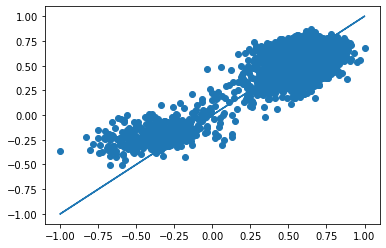

In [46]:
X_np = torch.Tensor(X).numpy()
ypred = reg.predict(X)

plt.scatter(tic0,ypred)
plt.plot(tic0,tic0)


In [49]:
ypred - np.dot(X_np,reg.coef_)

array([-0.43499636, -0.43499611, -0.43499637, ..., -0.43499577,
       -0.43499572, -0.43499659])

In [61]:
s='lasso: COMBINE ARG='
for i in range(len(reg.coef_)):
    if reg.coef_[i] != 0:
        s+= 'd%d'%(i+1)
        if i < len(reg.coef_) - 1:
            s+= ','
s+= ' COEFFICIENTS='

for i in range(len(reg.coef_)):
    if reg.coef_[i] != 0:
        s+= '%0.4f'%reg.coef_[i]
        if i < len(reg.coef_) - 1:
            s+= ','
s+= ' PERIODIC=NO'
print(s)
print(' ')

#correct for offset
offset = reg.intercept_
if offset>0:
    s2 = 'lassoCV: MATHEVAL ARG=lasso FUNC=x+%0.4f PERIODIC=NO'%offset
elif offset<0:
    s2 = 'lassoCV: MATHEVAL ARG=lasso FUNC=x%0.4f PERIODIC=NO'%offset
print(s2)

lasso: COMBINE ARG=d2,d3,d4,d5,d7,d9,d10,d12,d13,d15,d17,d19,d21,d22,d23,d24,d25,d26,d28,d29,d30,d31,d33,d35,d37,d38,d39,d40,d41,d43,d44,d45 COEFFICIENTS=-1.9143,-5.5083,16.8174,-6.4581,-1.6677,-1.5925,2.0461,-22.0852,16.9497,0.6931,7.9126,-2.5423,1.9503,2.0148,0.8934,-3.2581,6.3736,-6.4415,0.2779,-0.5664,-4.6661,-1.7653,-3.0007,0.6599,-0.5428,-0.5640,0.1342,2.4174,-3.5699,-0.3862,0.8194,3.8702 PERIODIC=NO
 
lassoCV: MATHEVAL ARG=lasso FUNC=x-0.4350 PERIODIC=NO
